In [17]:
from Functions import *
from DataDefined import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import combinations

In [2]:
df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

df, label_mappings = preprocessing(df, one_val_col, irrelevant_col, to_be_scaled_col, two_val_col, some_val_num_col, some_val_cat_col)

In [3]:
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])
print(encoder.classes_, encoder.transform(encoder.classes_))

#df = add_derivatives(df, delta_col)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'] [0 1 2 3 4 5 6 7 8 9]


In [4]:
## Class B versus D (where B is the known class)
X_train, y_train, X_test, y_test, X_val, y_val = getDataSplitForTwoDrivers(df, 1, 3, 42)

In [5]:
print(len(X_train), len(X_test), len(X_val))

8212 4668 5184


In [18]:
print(X_train[8212])

tensor([ 0.3002,  1.2205, -0.0312, -0.5441,  1.0425, -0.0466,  0.0000,  0.3824,
         0.1388, -0.7036,  0.9112,  0.8949, -0.0565,  0.0260,  0.7494,  0.4076,
         0.2439,  0.3266,  0.9052,  1.0000,  1.0000,  0.0935, -0.1079,  1.0000,
         1.0000,  0.3211,  0.7143,  0.3948,  0.5962,  0.5819,  0.5849,  0.5928,
         0.3211,  0.0000,  1.0000,  0.1667,  0.6117,  0.2971,  0.5000, -0.4732,
        -0.1359, -0.2210, -0.2404, -0.0867, -0.5235, -0.4372, -0.4064,  0.2139,
        -1.3182, -0.4025,  0.0000,  0.3039, -1.2354,  1.5396, -0.2744, -0.9258,
         0.4321, -1.2601, -0.0718,  0.4728,  0.2439, -1.4277, -0.2596,  1.0000,
         1.0000,  0.0935, -0.1079,  1.0000,  1.0000, -1.6440,  0.1429,  0.4681,
        -1.1372, -1.1188, -1.1197, -1.1362, -1.6443,  1.0000,  0.0000,  0.1667,
        -1.1268, -0.0401,  1.0000,  2.4145, -0.1359,  0.0182, -0.2404, -2.5466])


In [ ]:
def get_index(i, j, size):
    new_index = j+i
    if new_index > size:
        return new_index-size
    else:
        return new_index


def make_pairs_two_classes(df_driver1, df_driver2, head_size):
    # What I'm getting:
    # df_driver1: class B
    # df_driver2: Class D (OOD)

    # What I want:
    # Combinations of B-B and B-D/D-B

    ## split X into two 
    X_1, y_1 = split_into_X_and_y(df_driver1)
    X_2, y_2 = split_into_X_and_y(df_driver2)

    X_1 = X_1.head(head_size).to_numpy()
    y_1 = y_1.head(head_size).to_numpy()
    X_2 = X_2.head(head_size).to_numpy()
    y_2 = y_2.head(head_size).to_numpy()

    #### make combinations BB 
    X_bb = [sample_1 + sample_2 for sample_1, sample_2 in combinations(X_1.tolist(), 2)]
    y_bb = [int(group_1 == group_2) for group_1, group_2 in combinations(y_1.tolist(), 2)]

    #### make combination BD
    X_BD = []
    y_BD = []
    for i in range(0, 10):
        for j in range (0, len(X_1)):
            get_index = get_index(i, j, len(X_1))
            X_BD.append(X_1[j] + X_2[get_index])
            y_BD.append(int(y_1[j] == y_2[get_index]))

    X_pairwise = X_bb + X_BD
    y_pairwise = y_bb + y_BD

    return X_pairwise, y_pairwise





In [6]:
### MAKE THE PAIRS

from itertools import combinations

def create_pairs(X, source):
    """
    Function that creates pair vectors of samples in X, all combinations between samples in X are made. Pair vectors
    are made by concatenating two rows of X. The pair vectors are returned together with the labels, same_source (1) and 
    different_source (0). The label is same_source when source[sample_n] is the same as source[sample_p]; 
    if the sources are different, the label different_source is returned.
    
    return: numpy array X (features), numpy array y (labels)
    """
    # create all combinations for X and y
    X = [sample_1 + sample_2 for sample_1, sample_2 in combinations(X.tolist(), 2)]
    y = [int(group_1 == group_2) for group_1, group_2 in combinations(source.tolist(), 2)]
    return np.array(X), np.array(y)

In [7]:
X_train_np = X_train.head(400).to_numpy()
X_test_np = X_test.head(100).to_numpy()
X_val_np = X_val.head(100).to_numpy()
y_train_np = y_train.head(400).to_numpy()
y_test_np = y_test.head(100).to_numpy()
y_val_np = y_val.head(100).to_numpy()

In [8]:
X_train_pairs, y_train_pairs = create_pairs(X_train_np, y_train_np)
X_test_pairs, y_test_pairs = create_pairs(X_test_np, y_test_np)
X_val_pairs, y_val_pairs = create_pairs(X_val_np, y_val_np) 

In [9]:
print(len(X_train_pairs), len(X_test_pairs), len(X_val_pairs))

79800 4950 4950


### ONECLASS SVM

In [22]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataForSVM(df, 1, 3, 42)

NameError: name 'splitDataForSVM' is not defined

In [ ]:
X_train_np = X_train.head(400).to_numpy()
X_test_np = X_test.head(100).to_numpy()
X_val_np = X_val.head(100).to_numpy()
y_train_np = y_train.head(400).to_numpy()
y_test_np = y_test.head(100).to_numpy()
y_val_np = y_val.head(100).to_numpy()

In [ ]:
X_train_pairs, y_train_pairs = create_pairs(X_train_np, y_train_np)
X_test_pairs, y_test_pairs = create_pairs(X_test_np, y_test_np)
X_val_pairs, y_val_pairs = create_pairs(X_val_np, y_val_np) 

In [12]:
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

In [20]:
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)

oc_svm.fit(X_train_pairs, y_train_pairs)

OneClassSVM(gamma='auto', nu=0.01)

In [21]:
y_pred_test = oc_svm.predict(X_test_pairs)
print(y_pred_test[0:100])

print(y_test_pairs[0:100])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0
 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1
 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1]


In [ ]:
y_pred_test = oc_svm.predict(X_test_pairs)
y_pred_train = oc_svm.predict(X_train_pairs)

y_pred_test = [0 if x == -1 else 1 for x in y_pred_test]
y_pred_train = [0 if x == -1 else 1 for x in y_pred_train]

y_transf_train = [1] * len(y_train)
y_transf_test = [0] * len(y_test)

print(classification_report(y_transf_test, y_pred_test))

ValueError: Found input variables with inconsistent numbers of samples: [4668, 4950]

### TABULARNN

In [10]:
CLASS_OOD = 0 #since D is the unknown class

In [11]:
# Convert to input for the model
X_train = torch.tensor(X_train_pairs, dtype=torch.float32)
X_test = torch.tensor(X_test_pairs, dtype=torch.float32)
X_val = torch.tensor(X_val_pairs, dtype=torch.float32)

y_train = torch.tensor(y_train_pairs, dtype=torch.long)
y_test = torch.tensor(y_test_pairs, dtype=torch.long)
y_val = torch.tensor(y_val_pairs, dtype=torch.long)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

# To evaluate, the OOD prediction should be compared
# Therefore, change class number that is OOD in the testset to -1
y_test_ood = torch.where(y_test == CLASS_OOD, -1, y_test)
y_val_ood = torch.where(y_val == CLASS_OOD, -1, y_val)

torch.Size([79800, 88])
torch.Size([4950, 88])
torch.Size([4950, 88])
torch.Size([79800])
torch.Size([4950])
torch.Size([4950])


In [12]:
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,32)  
        self.fc4 = nn.Linear(32,2)   # Output layer: 2 classes
        self.relu = nn.RReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x)) #
        x = self.fc4(x)
        return x

In [13]:
input_dim = X_train.shape[1]   
model = TabularNN(input_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classifications
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [14]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)  # Logits output
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)  # Logits
    # Convert logits to probabilities (using softmax) and get predicted class
    predicted_probs = torch.softmax(test_predictions, dim=1)
    max_probs, predicted_classes = torch.max(predicted_probs, dim=1)
    threshold = 0.99995   #0.999999 
    predicted_classes[max_probs < threshold] = -1  

# Normally, one would also calculate the test loss; however, now we have prediction -1, 
# so not sure how to handle that in the loss calculation 
print("Predicted Classes (with OOD detection):", predicted_classes)

Epoch 0, Loss: 0.7543
Epoch 10, Loss: 0.4770
Epoch 20, Loss: 0.1110
Epoch 30, Loss: 0.0064
Epoch 40, Loss: 0.0006
Epoch 50, Loss: 0.0002
Epoch 60, Loss: 0.0001
Epoch 70, Loss: 0.0001
Epoch 80, Loss: 0.0001
Epoch 90, Loss: 0.0001
Predicted Classes (with OOD detection): tensor([-1, -1,  1,  ...,  1,  1, -1])


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_ood, predicted_classes)
print(cm)

[[1898  586]
 [1815  651]]


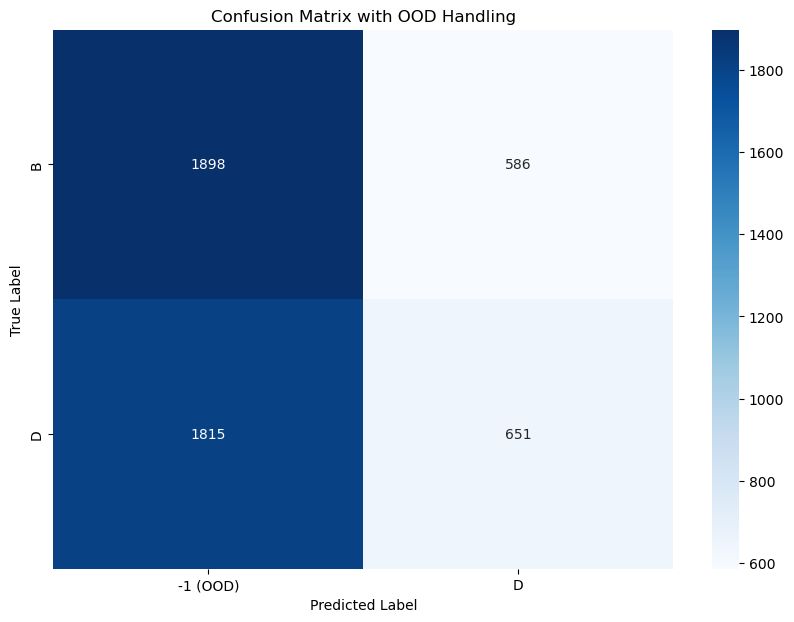

In [16]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_ood, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= ['-1 (OOD)',  'D', ], 
            yticklabels= ['B',  'D'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix with OOD Handling')
plt.show()

In [30]:
print(classification_report(y_test_ood, predicted_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2484
           1       0.50      1.00      0.67      2466

    accuracy                           0.50      4950
   macro avg       0.25      0.50      0.33      4950
weighted avg       0.25      0.50      0.33      4950



c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
